In [1]:
#instructions:
#use 'train' / 'test' to pass into classifier models 
#numpy and pandas are only used for visualisation of data

In [2]:
import findspark
findspark.init()
findspark.find()

'C:\\spark\\spark-3.1.2-bin-hadoop2.7'

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from datetime import datetime

sns.set(rc={'figure.figsize':(10,10)})

import matplotlib.pyplot as plt

In [4]:
import pyspark
from pyspark.sql import SparkSession

from pyspark.sql.window import Window
import pyspark.sql.functions
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import OneHotEncoder, OneHotEncoderModel
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.mllib.evaluation import BinaryClassificationMetrics


import pyspark.ml.evaluation as evals
from pyspark.ml.classification import LogisticRegression
import pyspark.ml.tuning as tune



In [5]:
spark = SparkSession.builder.appName('A2').getOrCreate()
sparkContext=spark.sparkContext

In [6]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [7]:
#col headers are : date ,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type

In [8]:
# in Python 
df = spark.read.csv("Steel_industry_data.csv", header=True, inferSchema=True)
df.show(truncate=False) 

+----------------+---------+------------------------------------+------------------------------------+---------+----------------------------+----------------------------+-----+----------+-----------+----------+
|date            |Usage_kWh|Lagging_Current_Reactive.Power_kVarh|Leading_Current_Reactive_Power_kVarh|CO2(tCO2)|Lagging_Current_Power_Factor|Leading_Current_Power_Factor|NSM  |WeekStatus|Day_of_week|Load_Type |
+----------------+---------+------------------------------------+------------------------------------+---------+----------------------------+----------------------------+-----+----------+-----------+----------+
|01/01/2018 00:15|3.17     |2.95                                |0.0                                 |0.0      |73.21                       |100.0                       |900  |Weekday   |Monday     |Light_Load|
|01/01/2018 00:30|4.0      |4.46                                |0.0                                 |0.0      |66.77                       |100.0          

In [9]:
## check the schema
df.printSchema()

root
 |-- date: string (nullable = true)
 |-- Usage_kWh: double (nullable = true)
 |-- Lagging_Current_Reactive.Power_kVarh: double (nullable = true)
 |-- Leading_Current_Reactive_Power_kVarh: double (nullable = true)
 |-- CO2(tCO2): double (nullable = true)
 |-- Lagging_Current_Power_Factor: double (nullable = true)
 |-- Leading_Current_Power_Factor: double (nullable = true)
 |-- NSM: integer (nullable = true)
 |-- WeekStatus: string (nullable = true)
 |-- Day_of_week: string (nullable = true)
 |-- Load_Type: string (nullable = true)



In [10]:
df.dtypes

[('date', 'string'),
 ('Usage_kWh', 'double'),
 ('Lagging_Current_Reactive.Power_kVarh', 'double'),
 ('Leading_Current_Reactive_Power_kVarh', 'double'),
 ('CO2(tCO2)', 'double'),
 ('Lagging_Current_Power_Factor', 'double'),
 ('Leading_Current_Power_Factor', 'double'),
 ('NSM', 'int'),
 ('WeekStatus', 'string'),
 ('Day_of_week', 'string'),
 ('Load_Type', 'string')]

In [11]:
df2 = df.withColumnRenamed("Usage_kWh","Usage").withColumnRenamed("Lagging_Current_Reactive.Power_kVarh","Lagging_rp").withColumnRenamed("Leading_Current_Reactive_Power_kVarh","Leading_rp").withColumnRenamed("CO2(tCO2)","CO2").withColumnRenamed("Lagging_Current_Power_Factor","Lagging_pf").withColumnRenamed("Leading_Current_Power_Factor","Leading_pf").withColumnRenamed("WeekStatus","week").withColumnRenamed("Day_of_week","day").withColumnRenamed("Load_Type","loadtype")
df2.show()

+----------------+-----+----------+----------+---+----------+----------+-----+-------+------+----------+
|            date|Usage|Lagging_rp|Leading_rp|CO2|Lagging_pf|Leading_pf|  NSM|   week|   day|  loadtype|
+----------------+-----+----------+----------+---+----------+----------+-----+-------+------+----------+
|01/01/2018 00:15| 3.17|      2.95|       0.0|0.0|     73.21|     100.0|  900|Weekday|Monday|Light_Load|
|01/01/2018 00:30|  4.0|      4.46|       0.0|0.0|     66.77|     100.0| 1800|Weekday|Monday|Light_Load|
|01/01/2018 00:45| 3.24|      3.28|       0.0|0.0|     70.28|     100.0| 2700|Weekday|Monday|Light_Load|
|01/01/2018 01:00| 3.31|      3.56|       0.0|0.0|     68.09|     100.0| 3600|Weekday|Monday|Light_Load|
|01/01/2018 01:15| 3.82|       4.5|       0.0|0.0|     64.72|     100.0| 4500|Weekday|Monday|Light_Load|
|01/01/2018 01:30| 3.28|      3.56|       0.0|0.0|     67.76|     100.0| 5400|Weekday|Monday|Light_Load|
|01/01/2018 01:45|  3.6|      4.14|       0.0|0.0|     

In [12]:
df2.groupBy('loadtype').count().orderBy('count').show()

+------------+-----+
|    loadtype|count|
+------------+-----+
|Maximum_Load| 7272|
| Medium_Load| 9696|
|  Light_Load|18072|
+------------+-----+



In [13]:
df2.groupBy('loadtype').count().orderBy('count', ascending=False).show()

+------------+-----+
|    loadtype|count|
+------------+-----+
|  Light_Load|18072|
| Medium_Load| 9696|
|Maximum_Load| 7272|
+------------+-----+



We now know that this is a ternary classification problem. <br> and light load has the highest occurences among the three classes

In [14]:
#checking for null values using SQL query:
df2.select([count(when(col(c).contains('None') | col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c )).alias(c) for c in df2.columns]).show()

+----+-----+----------+----------+---+----------+----------+---+----+---+--------+
|date|Usage|Lagging_rp|Leading_rp|CO2|Lagging_pf|Leading_pf|NSM|week|day|loadtype|
+----+-----+----------+----------+---+----------+----------+---+----+---+--------+
|   0|    0|         0|         0|  0|         0|         0|  0|   0|  0|       0|
+----+-----+----------+----------+---+----------+----------+---+----+---+--------+



Great! There are no null values. :)

In [15]:
df3 = df2.drop('date')
df3.show()

+-----+----------+----------+---+----------+----------+-----+-------+------+----------+
|Usage|Lagging_rp|Leading_rp|CO2|Lagging_pf|Leading_pf|  NSM|   week|   day|  loadtype|
+-----+----------+----------+---+----------+----------+-----+-------+------+----------+
| 3.17|      2.95|       0.0|0.0|     73.21|     100.0|  900|Weekday|Monday|Light_Load|
|  4.0|      4.46|       0.0|0.0|     66.77|     100.0| 1800|Weekday|Monday|Light_Load|
| 3.24|      3.28|       0.0|0.0|     70.28|     100.0| 2700|Weekday|Monday|Light_Load|
| 3.31|      3.56|       0.0|0.0|     68.09|     100.0| 3600|Weekday|Monday|Light_Load|
| 3.82|       4.5|       0.0|0.0|     64.72|     100.0| 4500|Weekday|Monday|Light_Load|
| 3.28|      3.56|       0.0|0.0|     67.76|     100.0| 5400|Weekday|Monday|Light_Load|
|  3.6|      4.14|       0.0|0.0|     65.62|     100.0| 6300|Weekday|Monday|Light_Load|
|  3.6|      4.28|       0.0|0.0|     64.37|     100.0| 7200|Weekday|Monday|Light_Load|
| 3.28|      3.64|       0.0|0.0

In [16]:
df2.select("day").distinct().show()

+---------+
|      day|
+---------+
|Wednesday|
|  Tuesday|
|   Friday|
| Thursday|
| Saturday|
|   Monday|
|   Sunday|
+---------+



In [17]:
df2.select("Week").distinct().show()

+-------+
|   Week|
+-------+
|Weekday|
|Weekend|
+-------+



### Using user-defined function to transform the date column 
Creates a new column with the name of the month

In [18]:
# change date column from string to datetime
df_formated_date = df2.withColumn("new_date", to_date(col("date"), "dd/MM/yyyy HH:mm"))

In [19]:
df_formated_date.printSchema()

root
 |-- date: string (nullable = true)
 |-- Usage: double (nullable = true)
 |-- Lagging_rp: double (nullable = true)
 |-- Leading_rp: double (nullable = true)
 |-- CO2: double (nullable = true)
 |-- Lagging_pf: double (nullable = true)
 |-- Leading_pf: double (nullable = true)
 |-- NSM: integer (nullable = true)
 |-- week: string (nullable = true)
 |-- day: string (nullable = true)
 |-- loadtype: string (nullable = true)
 |-- new_date: date (nullable = true)



In [20]:
df_formated_date.show()

+----------------+-----+----------+----------+---+----------+----------+-----+-------+------+----------+----------+
|            date|Usage|Lagging_rp|Leading_rp|CO2|Lagging_pf|Leading_pf|  NSM|   week|   day|  loadtype|  new_date|
+----------------+-----+----------+----------+---+----------+----------+-----+-------+------+----------+----------+
|01/01/2018 00:15| 3.17|      2.95|       0.0|0.0|     73.21|     100.0|  900|Weekday|Monday|Light_Load|2018-01-01|
|01/01/2018 00:30|  4.0|      4.46|       0.0|0.0|     66.77|     100.0| 1800|Weekday|Monday|Light_Load|2018-01-01|
|01/01/2018 00:45| 3.24|      3.28|       0.0|0.0|     70.28|     100.0| 2700|Weekday|Monday|Light_Load|2018-01-01|
|01/01/2018 01:00| 3.31|      3.56|       0.0|0.0|     68.09|     100.0| 3600|Weekday|Monday|Light_Load|2018-01-01|
|01/01/2018 01:15| 3.82|       4.5|       0.0|0.0|     64.72|     100.0| 4500|Weekday|Monday|Light_Load|2018-01-01|
|01/01/2018 01:30| 3.28|      3.56|       0.0|0.0|     67.76|     100.0|

In [21]:
from pyspark.sql.functions import udf

#@pandas_udf("string")
def month_to_string(month):
    if(month==1):
        return 'January'
    elif(month==2):
        return 'February'
    elif(month==3):
        return 'March'
    elif(month==4):
        return 'April'
    elif(month==5):
        return 'May'
    elif(month==6):
        return 'June'
    elif(month==7):
        return 'July'
    elif(month==8):
        return 'August'
    elif(month==9):
        return 'September'
    elif(month==10):
        return 'October'
    elif(month==11):
        return 'November'
    elif(month==12):
        return 'December'

In [22]:
month_udf = udf(month_to_string)

In [23]:
df_4 = df_formated_date.withColumn('month', month(df_formated_date.new_date))

In [24]:
df_final = df_4.drop('date','new_date')

In [25]:
df_1 = df_final.withColumn("month_string", month_udf(df_final['month']))

In [26]:
df_1.show()

+-----+----------+----------+---+----------+----------+-----+-------+------+----------+-----+------------+
|Usage|Lagging_rp|Leading_rp|CO2|Lagging_pf|Leading_pf|  NSM|   week|   day|  loadtype|month|month_string|
+-----+----------+----------+---+----------+----------+-----+-------+------+----------+-----+------------+
| 3.17|      2.95|       0.0|0.0|     73.21|     100.0|  900|Weekday|Monday|Light_Load|    1|     January|
|  4.0|      4.46|       0.0|0.0|     66.77|     100.0| 1800|Weekday|Monday|Light_Load|    1|     January|
| 3.24|      3.28|       0.0|0.0|     70.28|     100.0| 2700|Weekday|Monday|Light_Load|    1|     January|
| 3.31|      3.56|       0.0|0.0|     68.09|     100.0| 3600|Weekday|Monday|Light_Load|    1|     January|
| 3.82|       4.5|       0.0|0.0|     64.72|     100.0| 4500|Weekday|Monday|Light_Load|    1|     January|
| 3.28|      3.56|       0.0|0.0|     67.76|     100.0| 5400|Weekday|Monday|Light_Load|    1|     January|
|  3.6|      4.14|       0.0|0.0|    

### Final processed dataframe to use in Rformula

In [27]:
df_processed = df_1.drop('month')

In [28]:
df_processed.show()

+-----+----------+----------+---+----------+----------+-----+-------+------+----------+------------+
|Usage|Lagging_rp|Leading_rp|CO2|Lagging_pf|Leading_pf|  NSM|   week|   day|  loadtype|month_string|
+-----+----------+----------+---+----------+----------+-----+-------+------+----------+------------+
| 3.17|      2.95|       0.0|0.0|     73.21|     100.0|  900|Weekday|Monday|Light_Load|     January|
|  4.0|      4.46|       0.0|0.0|     66.77|     100.0| 1800|Weekday|Monday|Light_Load|     January|
| 3.24|      3.28|       0.0|0.0|     70.28|     100.0| 2700|Weekday|Monday|Light_Load|     January|
| 3.31|      3.56|       0.0|0.0|     68.09|     100.0| 3600|Weekday|Monday|Light_Load|     January|
| 3.82|       4.5|       0.0|0.0|     64.72|     100.0| 4500|Weekday|Monday|Light_Load|     January|
| 3.28|      3.56|       0.0|0.0|     67.76|     100.0| 5400|Weekday|Monday|Light_Load|     January|
|  3.6|      4.14|       0.0|0.0|     65.62|     100.0| 6300|Weekday|Monday|Light_Load|    

## Now for data visualization..

In [29]:
# convert to pandas dataframe for visualisation
pandasDF = df2.toPandas()

In [30]:
#pandasDF['date']= pd.to_datetime(pandasDF['date'])
pandasDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        35040 non-null  object 
 1   Usage       35040 non-null  float64
 2   Lagging_rp  35040 non-null  float64
 3   Leading_rp  35040 non-null  float64
 4   CO2         35040 non-null  float64
 5   Lagging_pf  35040 non-null  float64
 6   Leading_pf  35040 non-null  float64
 7   NSM         35040 non-null  int32  
 8   week        35040 non-null  object 
 9   day         35040 non-null  object 
 10  loadtype    35040 non-null  object 
dtypes: float64(6), int32(1), object(4)
memory usage: 2.8+ MB


Plotting a graph to see the distribution of load types per month in the year 2018

In [31]:
#split by month
pandasDF.date = pd.to_datetime(pandasDF.date)
pandasDF.loc[(pandasDF.loadtype == 'Maximum_Load'), 'loadtype'] = 'Maximum_Load'
pandasDF.loc[(pandasDF.loadtype == 'Light_Load'), 'loadtype'] = 'Light_Load'
pandasDF.loc[(pandasDF.loadtype == 'Medium_Load'), 'loadtype'] = 'Medium_Load'


new_df = pandasDF.groupby([pandasDF.date.dt.year,pandasDF.date.dt.month]).loadtype.value_counts().unstack().fillna(0)
new_df.columns = ['Maximum_Load','Light_Load','Medium_Load']
new_df.index.names = ['Year', 'Month']

In [32]:
new_df

Maximum_Load  Light_Load  Medium_Load
Year Month                                       
2018 1              1576         600          800
     2              1624         456          608
     3              1464         648          864
     4              1480         600          800
     5              1464         648          864
     6              1368         648          864
     7              1408         672          896
     8              1352         696          928
     9              1704         504          672
     10             1520         624          832
     11             1424         624          832
     12             1688         552          736

Text(0.5, 1.0, 'Frequency of load types per month in 2018')

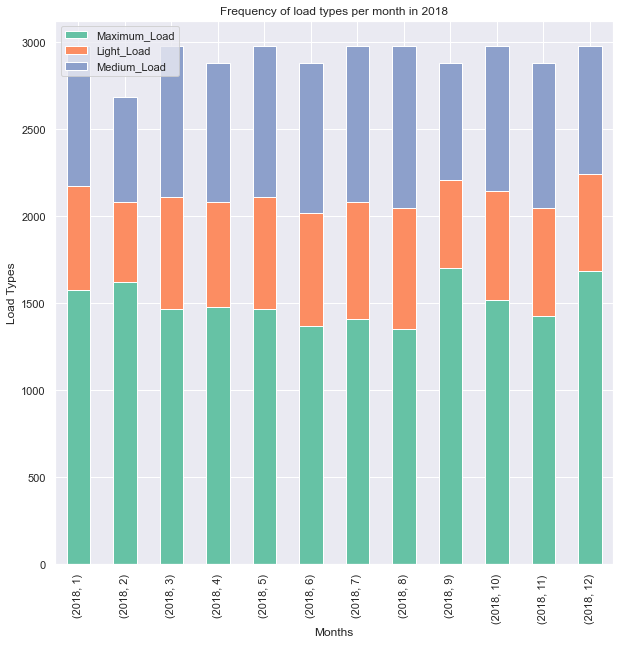

In [33]:
new_df.plot(kind='bar', stacked=True, color=sns.color_palette("Set2"))
plt.xlabel('Months')
plt.ylabel('Load Types')
plt.title('Frequency of load types per month in 2018')

In [34]:
#group by day 
pandasDF.loc[(pandasDF.loadtype == 'Maximum_Load'), 'loadtype'] = 'Maximum_Load'
pandasDF.loc[(pandasDF.loadtype == 'Light_Load'), 'loadtype'] = 'Light_Load'
pandasDF.loc[(pandasDF.loadtype == 'Medium_Load'), 'loadtype'] = 'Medium_Load'

new_df = pandasDF.groupby([pandasDF.day]).loadtype.value_counts().unstack().fillna(0)
new_df.columns = ['Light_Load','Maximum_Load','Medium_Load']
new_df.index.names = ['Day']

Text(0.5, 1.0, 'Frequency of load types for each day in 2018')

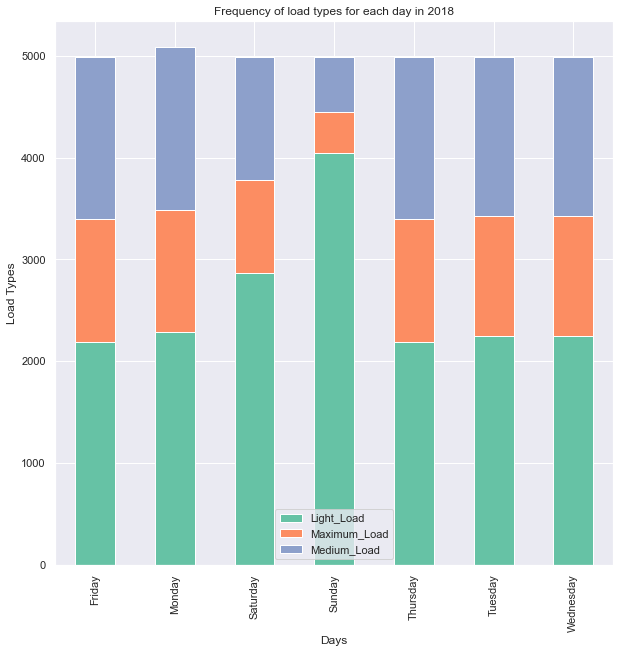

In [35]:
new_df.plot(kind='bar', stacked=True, color=sns.color_palette("Set2"))
plt.xlabel('Days')
plt.ylabel('Load Types')
plt.title('Frequency of load types for each day in 2018')

### Preparing data for training

In [36]:
#transform data into labels and features using RFormula
# The ordering option stringOrderType is NOT used for the label column.
# When the label column is indexed, 
# it uses the default descending frequency ordering in StringIndexer.
# Rformula just converts the strings, standarize them and parse them into a vector.

In [37]:
from pyspark.ml.feature import RFormula 
supervised = RFormula(formula="loadtype ~ .") 
final_DF = supervised.fit(df_processed).transform(df_processed)

In [38]:
final_DF.select('features').show(truncate=False)

+-------------------------------------------------------------------+
|features                                                           |
+-------------------------------------------------------------------+
|(25,[0,1,4,5,6,7,8,16],[3.17,2.95,73.21,100.0,900.0,1.0,1.0,1.0])  |
|(25,[0,1,4,5,6,7,8,16],[4.0,4.46,66.77,100.0,1800.0,1.0,1.0,1.0])  |
|(25,[0,1,4,5,6,7,8,16],[3.24,3.28,70.28,100.0,2700.0,1.0,1.0,1.0]) |
|(25,[0,1,4,5,6,7,8,16],[3.31,3.56,68.09,100.0,3600.0,1.0,1.0,1.0]) |
|(25,[0,1,4,5,6,7,8,16],[3.82,4.5,64.72,100.0,4500.0,1.0,1.0,1.0])  |
|(25,[0,1,4,5,6,7,8,16],[3.28,3.56,67.76,100.0,5400.0,1.0,1.0,1.0]) |
|(25,[0,1,4,5,6,7,8,16],[3.6,4.14,65.62,100.0,6300.0,1.0,1.0,1.0])  |
|(25,[0,1,4,5,6,7,8,16],[3.6,4.28,64.37,100.0,7200.0,1.0,1.0,1.0])  |
|(25,[0,1,4,5,6,7,8,16],[3.28,3.64,66.94,100.0,8100.0,1.0,1.0,1.0]) |
|(25,[0,1,4,5,6,7,8,16],[3.78,4.72,62.51,100.0,9000.0,1.0,1.0,1.0]) |
|(25,[0,1,4,5,6,7,8,16],[3.46,4.03,65.14,100.0,9900.0,1.0,1.0,1.0]) |
|(25,[0,1,4,5,6,7,8,

In [39]:
final_DF.select('label').distinct().show(truncate=False)

+-----+
|label|
+-----+
|0.0  |
|1.0  |
|2.0  |
+-----+



In [40]:
final_DF.where(df3.loadtype=='Light_Load').show(3)

+-----+----------+----------+---+----------+----------+----+-------+------+----------+------------+--------------------+-----+
|Usage|Lagging_rp|Leading_rp|CO2|Lagging_pf|Leading_pf| NSM|   week|   day|  loadtype|month_string|            features|label|
+-----+----------+----------+---+----------+----------+----+-------+------+----------+------------+--------------------+-----+
| 3.17|      2.95|       0.0|0.0|     73.21|     100.0| 900|Weekday|Monday|Light_Load|     January|(25,[0,1,4,5,6,7,...|  0.0|
|  4.0|      4.46|       0.0|0.0|     66.77|     100.0|1800|Weekday|Monday|Light_Load|     January|(25,[0,1,4,5,6,7,...|  0.0|
| 3.24|      3.28|       0.0|0.0|     70.28|     100.0|2700|Weekday|Monday|Light_Load|     January|(25,[0,1,4,5,6,7,...|  0.0|
+-----+----------+----------+---+----------+----------+----+-------+------+----------+------------+--------------------+-----+
only showing top 3 rows



In [41]:
final_DF.where(df3.loadtype=='Medium_Load').show(3)

+-----+----------+----------+---+----------+----------+-----+-------+-------+-----------+------------+--------------------+-----+
|Usage|Lagging_rp|Leading_rp|CO2|Lagging_pf|Leading_pf|  NSM|   week|    day|   loadtype|month_string|            features|label|
+-----+----------+----------+---+----------+----------+-----+-------+-------+-----------+------------+--------------------+-----+
|56.84|      8.32|       0.0|0.0|     98.95|     100.0|33300|Weekday|Tuesday|Medium_Load|     January|(25,[0,1,4,5,6,7,...|  1.0|
|51.26|      4.54|      0.94|0.0|     99.61|     99.98|34200|Weekday|Tuesday|Medium_Load|     January|(25,[0,1,2,4,5,6,...|  1.0|
|48.13|      2.34|      1.15|0.0|     99.88|     99.97|35100|Weekday|Tuesday|Medium_Load|     January|(25,[0,1,2,4,5,6,...|  1.0|
+-----+----------+----------+---+----------+----------+-----+-------+-------+-----------+------------+--------------------+-----+
only showing top 3 rows



In [42]:
# Light_Load = 0
# Medium_Load = 1
# Maximum_Load = 2

## Splitting dataset into trainining and testing , retaining the ratio of classes in each dataset

In [43]:
#taking 0.666% of all labels into training set:
train = final_DF.sampleBy("label", fractions={ 0 : 0.666, 
                                        1 : 0.666,
                                        2 : 0.666}, seed=10)

In [44]:
#checking distribution of labels in the training dataset
train.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|12032|
|  1.0| 6415|
|  2.0| 4860|
+-----+-----+



In [45]:
final_DF.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|18072|
|  1.0| 9696|
|  2.0| 7272|
+-----+-----+



In [46]:
# check that train is roughly 0.66% of data set
print(train.count())
print(final_DF.count())

23307
35040


In [47]:
#extracting the test data set by subtracting the training dataset from the original
test = final_DF.subtract(train)

In [48]:
# checking that the distribution of the classes is correct
test.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 6032|
|  1.0| 3281|
|  2.0| 2412|
+-----+-----+



# Decision Tree Classifier 

In [49]:
bInput = train.selectExpr("features", "cast(label as double) as label") 

In [50]:
dtc = DecisionTreeClassifier()

In [51]:
print(dtc.explainParams())  

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins for discretizing continuous features.  Must be 

In [52]:
dtcModel = dtc.fit(bInput)

In [53]:
predict_dtc = dtcModel.transform(bInput)

In [54]:
predict_dtc.show(5)

+--------------------+-----+----------------+-------------+----------+
|            features|label|   rawPrediction|  probability|prediction|
+--------------------+-----+----------------+-------------+----------+
|(25,[0,1,4,5,6,7,...|  0.0|[8781.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|(25,[0,1,4,5,6,7,...|  0.0|[8781.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|(25,[0,1,4,5,6,7,...|  0.0|[8781.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|(25,[0,1,4,5,6,7,...|  0.0|[8781.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|(25,[0,1,4,5,6,7,...|  0.0|[8781.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
+--------------------+-----+----------------+-------------+----------+
only showing top 5 rows



In [55]:
evaluator_dtc = MulticlassClassificationEvaluator(predictionCol="prediction")

In [56]:
acc = evaluator_dtc.evaluate(predict_dtc)
print("Prediction Accuracy: ", acc)

Prediction Accuracy:  0.8550481324812342


In [57]:
dtcModel.featureImportances

SparseVector(25, {0: 0.1786, 2: 0.0461, 6: 0.728, 11: 0.0338, 16: 0.0135})

In [58]:
#tuning decision tree

assembler = VectorAssembler(
  inputCols = ['Usage_kWh',
 'Lagging_Current_Reactive.Power_kVarh',
 'Leading_Current_Reactive_Power_kVarh',
 'CO2(tCO2)',
 'Lagging_Current_Power_Factor',
 'Leading_Current_Power_Factor',
 'NSM',
 'WeekStatus',
 'Day_of_week',
 'Load_Type'],
  outputCol = "features")

In [59]:
classifier = DecisionTreeClassifier(featuresCol="features", labelCol="label")

In [60]:
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(test)

In [61]:
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(predict_dtc)

In [62]:
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, classifier])

In [63]:
model = pipeline.fit(test)

In [64]:
predictions = model.transform(test)

In [65]:
predictions.select("prediction", "indexedLabel", "features").show(5)

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       2.0|         1.0|(25,[0,1,3,4,5,6,...|
|       1.0|         1.0|(25,[0,2,4,5,6,7,...|
|       2.0|         1.0|(25,[0,1,2,3,4,5,...|
|       1.0|         2.0|(25,[0,1,4,5,6,7,...|
|       2.0|         2.0|(25,[0,1,3,4,5,6,...|
+----------+------------+--------------------+
only showing top 5 rows



In [66]:
accuracy_dtc = evaluator_dtc.evaluate(predictions)
accuracy_dtc = evaluator_dtc.evaluate(predictions)
print('Test Error = %g' % (1.0 - accuracy_dtc))
print('Accuracy = %g' % (accuracy_dtc))

Test Error = 0.143923
Accuracy = 0.856077


In [67]:
paramGrid = ParamGridBuilder() \
 .addGrid(classifier.maxDepth, [10, 20, 30]) \
 .addGrid(classifier.maxBins, [300, 400, 500]) \
 .build()

In [68]:
tvs = TrainValidationSplit(
  estimator=pipeline,
  estimatorParamMaps=paramGrid,
  evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction"),
  trainRatio=0.6)  # data is separated by 66% and 33%, in which the former is used for training and the latter for evaluation
model = tvs.fit(test)

In [69]:
list(zip(model.validationMetrics, model.getEstimatorParamMaps()))

[(0.9524972126533049,
  {Param(parent='DecisionTreeClassifier_c370dfbee594', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10,
   Param(parent='DecisionTreeClassifier_c370dfbee594', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 300}),
 (0.9529084218703203,
  {Param(parent='DecisionTreeClassifier_c370dfbee594', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10,
   Param(parent='DecisionTreeClassifier_c370dfbee594', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 400}),
 (0.9512143278709987,
  {Param(parent='DecisionTreeClassifier_c370dfbee594', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g

# random forest classifier

In [70]:
rfc = RandomForestClassifier()

In [71]:
print(rfc.explainParams())

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

In [72]:
rfcModel = rfc.fit(bInput)

In [73]:
predict_rfc = rfcModel.transform(bInput)

In [74]:
predict_rfc.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(25,[0,1,4,5,6,7,...|  0.0|[19.4316868470761...|[0.97158434235380...|       0.0|
|(25,[0,1,4,5,6,7,...|  0.0|[19.4316868470761...|[0.97158434235380...|       0.0|
|(25,[0,1,4,5,6,7,...|  0.0|[19.3852743796923...|[0.96926371898461...|       0.0|
|(25,[0,1,4,5,6,7,...|  0.0|[19.4316868470761...|[0.97158434235380...|       0.0|
|(25,[0,1,4,5,6,7,...|  0.0|[19.3852743796923...|[0.96926371898461...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [75]:
predict_rfc.select('label', 'prediction', 'probability').show(5)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.97158434235380...|
|  0.0|       0.0|[0.97158434235380...|
|  0.0|       0.0|[0.96926371898461...|
|  0.0|       0.0|[0.97158434235380...|
|  0.0|       0.0|[0.96926371898461...|
+-----+----------+--------------------+
only showing top 5 rows



In [76]:
predict_rfc.head()

Row(features=SparseVector(25, {0: 3.17, 1: 2.95, 4: 73.21, 5: 100.0, 6: 900.0, 7: 1.0, 8: 1.0, 16: 1.0}), label=0.0, rawPrediction=DenseVector([19.4317, 0.4396, 0.1287]), probability=DenseVector([0.9716, 0.022, 0.0064]), prediction=0.0)

In [77]:
evaluator_rfc = MulticlassClassificationEvaluator(predictionCol="prediction")

In [78]:
evaluator_rfc.setMetricName("accuracy").evaluate(predict_rfc)
evaluator_rfc.setMetricName("f1").evaluate(predict_rfc)

0.7899338356918402

In [79]:
#fine tuning random forest using grid search
subSample = test.sample(fraction=1.0/120, withReplacement=False).cache()
print('We will use',subSample.count(),' events for the grid search.')


We will use 106  events for the grid search.


In [80]:
rf = RandomForestClassifier(labelCol='label', featuresCol='features', 
                            maxBins=20, subsamplingRate=0.6,
                            minInfoGain= 1e-05,
                            featureSubsetStrategy='all',
                            minInstancesPerNode=2)

In [81]:
paramGrid_rf = ParamGridBuilder()\
  .addGrid(rf.maxDepth, [2,4,10])\
  .addGrid(rf.numTrees, [100, 250, 600,800,1000])\
  .build()

In [82]:
# We define an evaluation metric.  This tells CrossValidator how well we are doing by comparing the true labels with predictions.
evaluator = MulticlassClassificationEvaluator(metricName="f1", labelCol=rf.getLabelCol(), predictionCol=rf.getPredictionCol())
# Declare the CrossValidator, which runs model tuning for us.
cv_rfc = CrossValidator(estimator=rf, 
                        evaluator=evaluator, 
                        estimatorParamMaps=paramGrid_rf,
                        numFolds=3)


In [83]:
rfcModel=cv_rfc.fit(subSample) 

In [86]:
print(rfcModel)

CrossValidatorModel_067c1e0991c4


In [92]:
rfc_best = rfcModel.transform(subSample)
rfc_best.show(5)

+-----+----------+----------+----+----------+----------+-----+-------+---------+------------+------------+--------------------+-----+--------------------+--------------------+----------+
|Usage|Lagging_rp|Leading_rp| CO2|Lagging_pf|Leading_pf|  NSM|   week|      day|    loadtype|month_string|            features|label|       rawPrediction|         probability|prediction|
+-----+----------+----------+----+----------+----------+-----+-------+---------+------------+------------+--------------------+-----+--------------------+--------------------+----------+
| 3.17|      4.28|       0.0| 0.0|     59.52|     100.0|18900|Weekend| Saturday|  Light_Load|    November|(25,[0,1,4,5,6,10...|  0.0|[99.0976148484247...|[0.99097614848424...|       0.0|
| 2.81|       0.0|     11.59| 0.0|     100.0|     23.56|47700|Weekend|   Sunday|  Light_Load|   September|(25,[0,2,4,5,6,11...|  0.0|[90.9001885900425...|[0.90900188590042...|       0.0|
|26.53|      1.19|      1.37|0.01|      99.9|     99.87|63900|Wee

In [93]:
print(evaluator.evaluate(rfc_best))

0.9332841558160309


# logistic regression classifier

In [94]:
bInput.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(25,[0,1,4,5,6,7,...|  0.0|
|(25,[0,1,4,5,6,7,...|  0.0|
|(25,[0,1,4,5,6,7,...|  0.0|
|(25,[0,1,4,5,6,7,...|  0.0|
|(25,[0,1,4,5,6,7,...|  0.0|
|(25,[0,1,4,5,6,7,...|  0.0|
|(25,[0,1,4,5,6,7,...|  0.0|
|(25,[0,1,4,5,6,7,...|  0.0|
|(25,[0,1,4,5,6,7,...|  0.0|
|(25,[0,1,4,5,6,7,...|  0.0|
|(25,[0,1,4,5,6,7,...|  0.0|
|(25,[0,1,4,5,6,7,...|  0.0|
|(25,[0,1,4,5,6,7,...|  0.0|
|(25,[0,1,4,5,6,7,...|  0.0|
|(25,[0,1,4,5,6,7,...|  0.0|
|(25,[0,1,4,5,6,7,...|  0.0|
|(25,[0,1,4,5,6,7,...|  0.0|
|(25,[0,1,4,5,6,7,...|  0.0|
|(25,[0,1,4,5,6,7,...|  0.0|
|(25,[0,1,4,5,6,7,...|  0.0|
+--------------------+-----+
only showing top 20 rows



In [95]:
cInput = test.selectExpr("features", "cast(label as double) as label")

In [96]:
cInput.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(25,[0,1,3,4,5,6,...|  1.0|
|(25,[0,2,4,5,6,7,...|  1.0|
|(25,[0,1,2,3,4,5,...|  1.0|
|(25,[0,1,4,5,6,7,...|  2.0|
|(25,[0,1,3,4,5,6,...|  2.0|
|(25,[0,1,4,5,6,7,...|  0.0|
|(25,[0,1,3,4,5,6,...|  1.0|
|(25,[0,1,2,3,4,5,...|  1.0|
|(25,[0,1,3,4,5,6,...|  1.0|
|(25,[0,1,4,5,6,10...|  0.0|
|(25,[0,1,2,3,4,5,...|  1.0|
|(25,[0,1,3,4,5,6,...|  2.0|
|(25,[0,1,3,4,5,6,...|  2.0|
|(25,[0,1,3,4,5,6,...|  2.0|
|(25,[0,2,4,5,6,7,...|  1.0|
|(25,[0,1,4,5,6,7,...|  0.0|
|(25,[0,1,3,4,5,6,...|  2.0|
|(25,[0,2,4,5,6,11...|  0.0|
|(25,[0,2,4,5,6,7,...|  0.0|
|(25,[0,2,4,5,6,7,...|  1.0|
+--------------------+-----+
only showing top 20 rows



In [97]:
lr = LogisticRegression() 

In [98]:
#train model
lrModel = lr.fit(bInput) 

In [99]:
print("Coefficients:" , lrModel.coefficientMatrix)
print("Intercept:" , lrModel.interceptVector) 

Coefficients: DenseMatrix([[-9.66791224e-02,  8.45465175e-02, -2.30153877e-01,
               5.64577154e+01, -6.45828848e-02, -7.35019141e-02,
              -4.94360844e-05,  1.14413030e+01,  1.83727562e-02,
               1.00341970e-01,  1.18524364e+01,  1.27161317e+01,
               1.19494845e-01,  1.77158263e-01, -1.74214307e+00,
              -6.79562290e-01, -3.96763740e-01, -2.29481481e+00,
              -1.36655471e+00, -1.60071689e+00, -2.21748598e+00,
              -1.71172650e+00, -1.84559711e+00, -1.57587166e+00,
              -2.31843211e+00],
             [ 6.38504511e-02, -7.84117848e-02,  1.19346625e-01,
              -2.74093415e+01,  1.18084949e-02,  1.94043482e-02,
               3.42452577e-05, -3.78862576e+00,  6.55123529e-02,
              -8.11529109e-03, -4.33654312e+00, -4.90167139e+00,
               7.73097327e-02, -2.74496902e-02,  1.03426428e+00,
               3.52210665e-01,  2.73015964e-01,  1.26015433e+00,
               7.08004614e-01,  8.53171682e-

In [100]:
# Make predictions.
predictions = lrModel.transform(cInput)
# Select example rows to display.
predictions.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(25,[0,1,3,4,5,6,...|  1.0|[-3.5335759652031...|[0.00248060112079...|       1.0|
|(25,[0,2,4,5,6,7,...|  1.0|[-0.9659328695447...|[0.07047768796314...|       1.0|
|(25,[0,1,2,3,4,5,...|  1.0|[-2.8721325474488...|[0.00667276647268...|       2.0|
|(25,[0,1,4,5,6,7,...|  2.0|[1.45329069172498...|[0.78646927209495...|       0.0|
|(25,[0,1,3,4,5,6,...|  2.0|[-0.4116765733897...|[0.18154466137097...|       2.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [101]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.22951


In [102]:
summary = lrModel.summary 

Light_Load = 0 <br>
Medium_Load = 1 <br>
Maximum_Load = 2

In [103]:
objectiveHistory = summary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

objectiveHistory:
1.0233212397836577
0.9688454276740561
0.9097658673073872
0.7041156199419196
0.6738714455375906
0.6477152171732009
0.6387441981335752
0.6183201038541539
0.6053318159904975
0.5892746161406399
0.5695558450047382
0.5546919687762313
0.5407445590696522
0.5235693967068195
0.518571777702888
0.5175264178361899
0.5164086719738762
0.5162467947038777
0.5150238054968461
0.5142453159275436
0.5128753144630311
0.5108798296742327
0.5067139269650872
0.5024002271866834
0.49929615219805035
0.49826616564998133
0.4971339734421706
0.496967806215201
0.49604584212564884
0.4952567197111512
0.4945965671713219
0.49382529910281975
0.49348034262532614
0.49289428410310326
0.4921819883524912
0.4902577529017682
0.4890485742164363
0.4882118513944619
0.4873587322464248
0.48641171013331536
0.4847902971377141
0.48419343328493036
0.48353509111705567
0.48244814382391715
0.4820496510738408
0.48145679122276575
0.4809221066080055
0.479980529329635
0.47865626693842367
0.47575349567645503
0.4751718187493814
0.4

In [104]:
#maxIter=10, regParam=0.3, elasticNetParam=0.8, family='multinomial'

In [105]:
# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(summary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

False positive rate by label:
label 0: 0.09906873614190688
label 1: 0.11739284868576841
label 2: 0.11812218788962975


In [106]:
print("True positive rate by label:")
for i, rate in enumerate(summary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

True positive rate by label:
label 0: 0.9207114361702128
label 1: 0.603273577552611
label 2: 0.6337448559670782


True positive rate for medium_load and maximum_load is very poor. We will have to fine tune this later on.. For now, lets continue evaluating this current model with raw data.

In [107]:
print("Precision by label:")
for i, prec in enumerate(summary.precisionByLabel):
    print("label %d: %s" % (i, prec))

Precision by label:
label 0: 0.9084050840508405
label 1: 0.6611993849308048
label 2: 0.5856626735120746


In [108]:
print("F-measure by label:")
for i, f in enumerate(summary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

F-measure by label:
label 0: 0.9145168613530358
label 1: 0.6309096837300293
label 2: 0.6087558059096748


In [109]:
accuracy = summary.accuracy
falsePositiveRate = summary.weightedFalsePositiveRate
truePositiveRate = summary.weightedTruePositiveRate
fMeasure = summary.weightedFMeasure()
precision = summary.weightedPrecision
recall = summary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Accuracy: 0.7735015231475523
FPR: 0.10808529586485727
TPR: 0.7735015231475522
F-measure: 0.772699434232157
Precision: 0.7730658007851507
Recall: 0.7735015231475522


### Plotting confusion matrix 

In [110]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[5542,  328,  162],
       [ 333, 1991,  957],
       [ 230,  681, 1501]], dtype=int64)

In [111]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix
[[5542  328  162]
 [ 333 1991  957]
 [ 230  681 1501]]


C:\Users\XenaI\AppData\Local\Temp\ipykernel_5332\1408026480.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


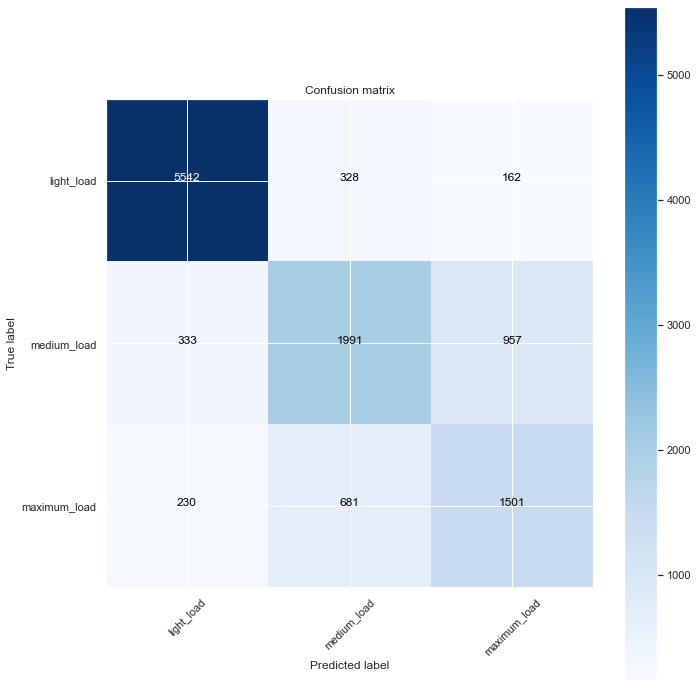

In [112]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["light_load","medium_load","maximum_load"],
                      title='Confusion matrix')
plt.show()

Overall accuracy is alright, could be improved. Lets fine tune it, although we have to beware of overfitting the train set.

In [113]:
# Create a MulticlassClassificationEvaluator
evaluator = evals.MulticlassClassificationEvaluator(metricName="f1")

In [114]:
# make grid of values to search over to look for optimal hyperparameters

In [115]:
# Create the parameter grid
grid = tune.ParamGridBuilder()

# Add the hyperparameter
grid = grid.addGrid(lr.regParam, np.arange(0, .8, .01))
grid = grid.addGrid(lr.elasticNetParam, [0, 1])

# Build the grid
grid = grid.build()

In [116]:
#instantiate cross validator and pass in grid
cv = tune.CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator)

In [117]:
best_lr = cv.fit(train)

# Print best_lr
print(best_lr)

CrossValidatorModel_c8ebb7049254


In [118]:
test_results = best_lr.transform(test)
test_results.show(5)

+------+----------+----------+----+----------+----------+-----+-------+---------+------------+------------+--------------------+-----+--------------------+--------------------+----------+
| Usage|Lagging_rp|Leading_rp| CO2|Lagging_pf|Leading_pf|  NSM|   week|      day|    loadtype|month_string|            features|label|       rawPrediction|         probability|prediction|
+------+----------+----------+----+----------+----------+-----+-------+---------+------------+------------+--------------------+-----+--------------------+--------------------+----------+
|111.89|     43.13|       0.0|0.05|     93.31|     100.0|54900|Weekday|   Monday| Medium_Load|     January|(25,[0,1,3,4,5,6,...|  1.0|[-2.2685056877884...|[0.01636253742143...|       2.0|
|  8.53|       0.0|     26.46| 0.0|     100.0|     30.68|45000|Weekday|Wednesday| Medium_Load|     January|(25,[0,2,4,5,6,7,...|  1.0|[0.35880504809131...|[0.31424173410166...|       1.0|
| 84.82|     31.25|      3.02|0.04|     93.83|     99.94|477

In [119]:
best_model = best_lr.bestModel

In [121]:
best_reg_param = best_model._java_obj.getRegParam()
best_elasticnet_param = best_model._java_obj.getElasticNetParam()

In [122]:
print("Best regParam:", best_reg_param)
print("Best elasticNetParam:", best_elasticnet_param)

Best regParam: 0.01
Best elasticNetParam: 0.0


In [123]:
# Evaluate the predictions
print(evaluator.evaluate(test_results))

0.7721554941937427


In [124]:
#method for visualising roc curve
from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [125]:
# Returns as a list (false positive rate, true positive rate)
preds = test_results.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

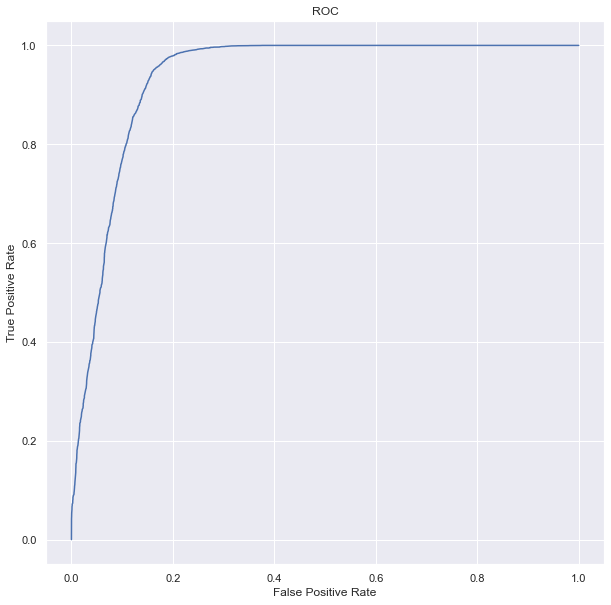

In [126]:
plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

In [127]:
metrics = CurveMetrics(preds)
metrics.get_curve('fMeasureByThreshold')
metrics.get_curve('precisionByThreshold')
metrics.get_curve('recallByThreshold')

[(0.9335702528283331, 0.0019321974354470403),
 (0.9286455317192643, 0.0038643948708940805),
 (0.9208736607644976, 0.005796592306341121),
 (0.9172349268226607, 0.007728789741788161),
 (0.9138460791496373, 0.009660987177235202),
 (0.9124004899394498, 0.010714913051115405),
 (0.9078746520095962, 0.012647110486562444),
 (0.9045164400996172, 0.014579307922009486),
 (0.9012632831677164, 0.016511505357456525),
 (0.8968161926443343, 0.018443702792903565),
 (0.894680802105564, 0.020375900228350605),
 (0.893811053857562, 0.02090286316529071),
 (0.8919713208751399, 0.02283506060073775),
 (0.8904820907998567, 0.024767258036184788),
 (0.8884623017915542, 0.026699455471631828),
 (0.884913981679812, 0.028631652907078867),
 (0.8826696009333942, 0.03056385034252591),
 (0.8819556188739434, 0.03126646759177938),
 (0.8800714520085161, 0.03319866502722642),
 (0.8770308082248484, 0.03513086246267346),
 (0.875442013121391, 0.0370630598981205),
 (0.8712556957778714, 0.03899525733356754),
 (0.869007183853256, 

In [128]:
y_true = test_results.select("label")
y_true = y_true.toPandas()

y_pred = test_results.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[5493,  362,  177],
       [ 356, 2017,  908],
       [ 191,  679, 1542]], dtype=int64)

Confusion matrix
[[5493  362  177]
 [ 356 2017  908]
 [ 191  679 1542]]


C:\Users\XenaI\AppData\Local\Temp\ipykernel_5332\1408026480.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


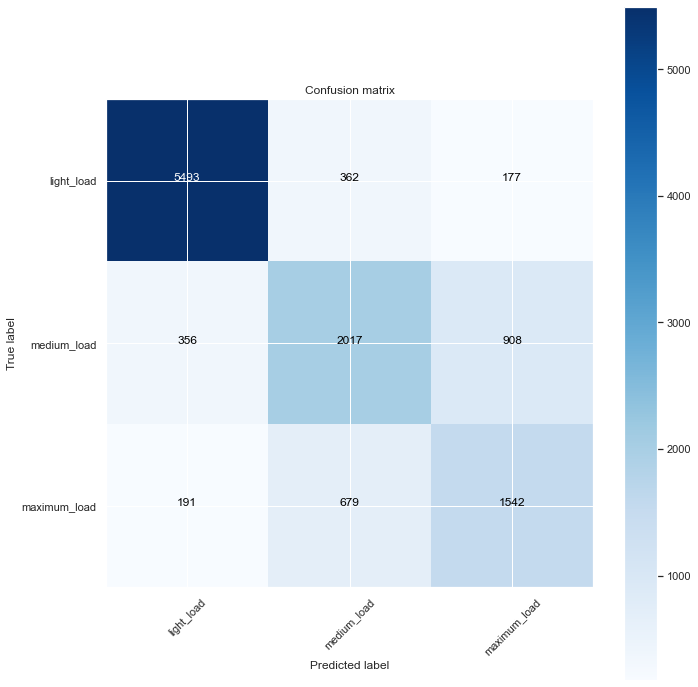

In [129]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["light_load","medium_load","maximum_load"],
                      title='Confusion matrix')
plt.show()

# Cons of using PySpark MLlib vs SciKit-Learn

1.Harder to use Spark vs SciKit-Learn

2.Spark uses more memory as compared to SciKit-Learn when executing the same thing

3.SciKit-Learn integrates well with Pandas and Numpy data structures but Spark uses its native dataframes or RDD to execute the computation

4.SciKit-Learn has a wider range of built in algorithms compared to Spark


# Pros of using PySpark MLlib vs SciKit-Learn

1.Spark is more powerful data processing tool compared to SciKit-Learn

2.We can use more than 1 CPUs to execute the ML process

3.Spark supports multiple languages(scala, java, sql, python)
